# Tp Final Data Science Digital House - Grupo 6 - MeliChallenge

## César Ybalo, Rodrigo Voena, Santiago Eslava, Tobías Canavesi y Agustín Galli

### Comenzamos cargando las librerias.

In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import csv
import pickle
import matplotlib.pyplot as plt
import multiprocessing as mp
from itertools import chain, islice
from datetime import timedelta
!pip install jsonlines
import jsonlines
import seaborn as sns
from pathlib import Path
import multiprocessing as mp
from itertools import chain, islice
import gzip
from scipy.stats import norm

### Comenzaremos cargandos todos los datos otorgados para el desafio:

Para descargar los datos ingresar: https://ml-challenge.mercadolibre.com/downloads

In [2]:
data_train = pd.read_parquet('train_data.parquet')
data_test = pd.read_csv('test_data.csv')

In [3]:
data_train.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0


In [4]:
data_test.head()

,sku,target_stock
0,464801,3
1,645793,4
2,99516,8
3,538100,8
4,557191,10


### Usamos una funcion auxiliar para cargar los jsonlines files

In [5]:
def load_jsonlines(filename):
    
    rv = []
    for obj in tqdm(jsonlines.open(filename)):
        rv.append(obj)
    return rv

In [6]:
item_metadata = load_jsonlines('items_static_metadata_full.jl')

660916it [00:26, 25097.37it/s]


#### Convertimos a df y usamos los sku como index

In [7]:
df_metadata = pd.DataFrame(item_metadata)
df_metadata.index = df_metadata.sku
df_metadata.drop(columns=['sku'],inplace=True)

In [8]:
df_metadata.head()

,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
sku,,,,,,
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,MLB,None,MLB15832732
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,MLB,None,None
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,MLM,None,None
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,MLM,None,None
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,MLB,None,None


In [9]:
df_metadata.dtypes

item_domain_id       object
item_id               int64
item_title           object
site_id              object
product_id           object
product_family_id    object
dtype: object

In [10]:
df_metadata.shape

(660916, 6)

### Ahora utilizemos la metadata integrandola a nuestros dataset de entrenamiento y testeo.

In [11]:
data_train = data_train.join(df_metadata, on='sku',how='left')

In [12]:
data_test = data_test.join(df_metadata, on='sku',how='left')

In [13]:
data_train.head(3)

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510


In [14]:
# maskbandm=(data_train['site_id']=='MLB') | (data_train['site_id']=='MLM')
# maskbandm2=(data_test['site_id']=='MLB') | (data_test['site_id']=='MLM')

In [15]:
# data_train=data_train[maskbandm]
# data_test=data_test[maskbandm2]

In [16]:
# data_train['site_id'].unique()

In [17]:
data_test.head(3)

,sku,target_stock,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
0,464801,3,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
1,645793,4,MLB-NEBULIZERS,438135,"Inalador Infantil, 2 Anos De Garantia, G-tech,...",MLB,None,MLB9838510
2,99516,8,MLB-ADHESIVE_TAPES,221252,Fita Dupla Face Preta Colar Touch Lcd 3mm Celu...,MLB,None,None


### Exploremos las columnas que tenemos:

In [18]:
for col in data_train.columns:
    print(col)

sku
date
sold_quantity
current_price
currency
listing_type
shipping_logistic_type
shipping_payment
minutes_active
item_domain_id
item_id
item_title
site_id
product_id
product_family_id


### Veamos algunas de las estadisticas por columna:

In [19]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [20]:
def describe_cols(cols,df):
    
    for col in cols: 
        print('\t COLUMN: ', col)
        print('\t type: ', df[col].dtype,'\n')
        print(df[col].describe(),'\n')

In [21]:
columns_to_describe = ['date','listing_type','current_price']

In [22]:
describe_cols(columns_to_describe,data_train)

	 COLUMN:  date
	 type:  object 

count       37660279
unique            59
top       2021-03-31
freq          660916
Name: date, dtype: object 

	 COLUMN:  listing_type
	 type:  object 

count     37660279
unique           2
top        classic
freq      18860849
Name: listing_type, dtype: object 

	 COLUMN:  current_price
	 type:  float64 

count    37660279.000
mean         2357.780
std       1263914.361
min             0.870
25%            48.700
50%           119.000
75%           298.590
max     999999999.000
Name: current_price, dtype: float64 



### Veamos las ventas agrupadas por día para los diferentes sitios (Mexico, Argentina y Brasil)

In [23]:
summary_site = data_train.groupby(['site_id','date']).sold_quantity.sum().reset_index()
summary_site.head()

,site_id,date,sold_quantity
0,MLA,2021-02-01,60141
1,MLA,2021-02-02,59987
2,MLA,2021-02-03,85528
3,MLA,2021-02-04,48553
4,MLA,2021-02-05,38558


In [24]:
def plot_time_series(summary_data,time_var,series,level):
    
    plt.figure(figsize=(15, 4))
    plt.title(f'{series} time series grouped by {level}')
    sns.lineplot(data=summary_data, 
                 x=time_var,y=series,hue=level)
    plt.xticks(rotation=45)
    plt.show()
    

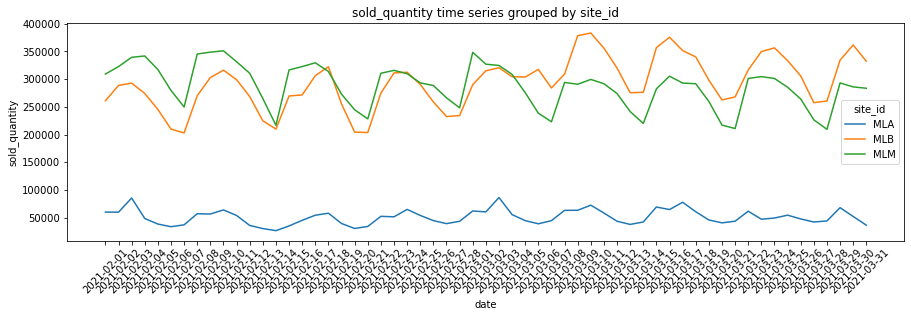

In [25]:
plot_time_series(summary_site, time_var='date',series='sold_quantity',level='site_id')

#### Se puede observar una estacionalidad 

In [26]:
# Definamos una nueva variable con el numero de semana
data_train['week'] = pd.to_datetime(data_train.date).dt.week

<ipython-input-26-9ec1db2efa79>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_train['week'] = pd.to_datetime(data_train.date).dt.week


In [27]:
# Juntando la info
summary_site_w = data_train.groupby(['site_id','week']).sold_quantity.sum().reset_index()

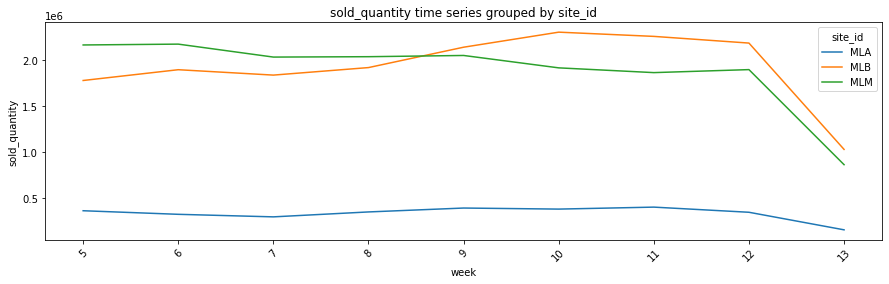

In [28]:
# La ploteamos
plot_time_series(summary_site_w,time_var='week',series='sold_quantity',level='site_id')

### Veamos cuales son las categorias que tienen mas cantidad de articulos vendidos, para los diferentes sitios.

In [29]:
def get_top_categories(df, categorical_var, site_id, by, N=10):
    
    grand_total = df[df.site_id == site_id][by].sum()
  
    top_cat_df = (df[df.site_id == site_id]
         .groupby(['site_id',categorical_var])[by]
         .sum()
         .sort_values(ascending=False)
         .head(N))
    
    top_cat_df = top_cat_df.reset_index()
    top_cat_df[f'relative_{by}'] = top_cat_df[by]/grand_total 
    
    return(top_cat_df[[categorical_var,by,f'relative_{by}']])

In [30]:
data_train['site_id'].unique()

array(['MLB', 'MLM', 'MLA'], dtype=object)

In [31]:
top_domains_MLM = get_top_categories(data_train, 
                                     categorical_var= 'item_domain_id',
                                     site_id='MLM', 
                                     by='sold_quantity', 
                                     N=10)
top_domains_MLM

,item_domain_id,sold_quantity,relative_sold_quantity
0,MLM-SURGICAL_MASKS,2902357,0.171
1,MLM-HEADPHONES,483957,0.029
2,MLM-CELLPHONE_COVERS,284810,0.017
3,MLM-OXIMETERS,224834,0.013
4,MLM-FACIAL_SKIN_CARE_PRODUCTS,220829,0.013
5,MLM-SAFETY_FACE_SHIELD_VISORS,166667,0.010
6,MLM-CELLPHONES,151931,0.009
7,MLM-SMARTWATCHES,148757,0.009
8,MLM-DATA_CABLES_AND_ADAPTERS,139243,0.008
9,MLM-WALL_AND_CEILING_LIGHTS,137134,0.008


In [ ]:
top_domains_MLB = get_top_categories(data_train, 
                                     categorical_var= 'item_domain_id',
                                     site_id='MLB', 
                                     by='sold_quantity', 
                                     N=10)
top_domains_MLB

In [ ]:
top_domains_MLA = get_top_categories(data_train, 
                                     categorical_var= 'item_domain_id',
                                     site_id='MLA', 
                                     by='sold_quantity', 
                                     N=10)
top_domains_MLA

In [ ]:
# Veamos si hay solapamiento entre los skus de entrenamiento y de testeo, esto es importante para saber 
# que vamos a poder una respuesta a la solicitud de mercado libre.
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [ ]:
def asses_overlap(df_train, df_test, key):
    
    figure, axes = plt.subplots(1, len(df_train.site_id.unique()),figsize=(16, 6))

    for i,site in enumerate(df_train.site_id.unique()):

        unique_train = df_train[df_train.site_id == site][key].unique()
        unique_test = df_test[df_test.site_id == site][key].unique()

        v = venn2(subsets=[set(unique_train),set(unique_test)],
                  set_labels = (f"Train \n ({len(unique_train)})", 
                        f"Test \n ({len(unique_test)}) "),
                  ax=axes[i],
                  set_colors=('purple', 'skyblue'), alpha = 0.6)
        axes[i].set_title(site)
    plt.show()
    

In [ ]:
asses_overlap(data_train, data_test, key='sku')

### Por suerte todos los sku estan contenidos.

### Plotemos alguna articulo en funcion de su precio y sus ventas

In [ ]:
site_id = 'MLA'
item_domain_id = 'MLA-COOKIES'
subset_data = data_train[(data_train.site_id == site_id)& (data_train.item_domain_id == item_domain_id)]

In [ ]:
subset_data['current_price'].hist(bins=100)

### Veamos la variable categorica shipping_logistic_type

In [ ]:
subset_data['shipping_logistic_type'].value_counts(normalize=True).plot.bar()

Estudiemos la relacion entre la cantidad vendida y los precios para algun item y su relacion con los minutos que
la publicacion estuvo activa

In [ ]:
site_id = 'MLA'
item_domain_id = 'MLA-CELLPHONES'
subset_data = data_train[(data_train.site_id == site_id)& (data_train.item_domain_id == item_domain_id)]

In [ ]:
def plot_bivariate(data,level, x, y, agg_x, agg_y):
    
    sns.scatterplot(data=data.groupby(level).agg(
        {x: agg_x,y: agg_y}),
                    x=x,y=y)
    plt.show()

In [ ]:
plot_bivariate(subset_data,
               x='current_price',
               level='sku',
               y='sold_quantity', 
               agg_x=np.mean, 
               agg_y=np.sum)

In [ ]:
plot_bivariate(subset_data,
               level='sku',
               x='minutes_active',
               y='sold_quantity', 
               agg_x=np.mean, 
               agg_y=np.sum)

### Ahora veamos un poco la distribucion que tiene el target stock 

In [ ]:
figure, axes = plt.subplots(1, 2,figsize=(14, 6))
figure.suptitle('Distribution of target stock')
sns.histplot(x=data_test.target_stock,bins=5000, kde=False, ax=axes[0])
axes[0].set_xlim(0,80)
sns.boxplot(x=data_test.target_stock, ax=axes[1])
axes[1].set_xlim(0,80)
plt.show()

### Cosntruyamos el conjunto de validacion

In [ ]:
data_train.date.min(), data_train.date.max()

In [ ]:
split_date = (pd.to_datetime(data_train.date).max()-timedelta(days=30)).date()
print(split_date)

In [ ]:
# Separemos los ultimos 30 días para validación
data_val = data_train.loc[(data_train.date > str(split_date))]

#y usemos el resto para entrenamiento
data_train = data_train.loc[(data_train.date <= str(split_date))]

In [ ]:
data_train.head(2)

In [ ]:
data_train.shape

In [ ]:
data_val.head(2)

##### Ahora vamos a construir el conjunto de datos de validación calculando el stock objetivo y los días de inventario.

In [ ]:
def create_validation_set(dataset):
    np.random.seed(42)
    print('Sorting records...')
    temp_pd = dataset.loc[:, ['sku','date','sold_quantity']].sort_values(['sku','date'])

    print('Grouping quantity...')
    temp_dict = temp_pd.groupby('sku').agg({'sold_quantity':lambda x: [i for i in x]})['sold_quantity'].to_dict()

    result = []
    for idx, list_quantity in tqdm(temp_dict.items(), desc='Making targets...'):
        cumsum = np.array(list_quantity).cumsum()
        stock_target = 0
        if cumsum[-1] > 0 and len(cumsum)==30:
            
            #choose a random target different from 0
            while stock_target == 0:
                stock_target = np.random.choice(cumsum)
                
            #get the first day with this amounnt of sales
            day_to_stockout = np.argwhere(cumsum==stock_target).min() + 1
            
            #add to a list
            result.append({'sku':idx, 'target_stock':stock_target, 'inventory_days':day_to_stockout})
    return result

#generate target for the 30 days of validation
val_dataset = create_validation_set(data_val)

In [ ]:
val_dataset[0:4]

In [ ]:
y_true_val = [x['inventory_days'] for x in val_dataset]

In [ ]:
y_true_val[0:5]

# El primer modelo que utilizaremos como base es considerar una distribucion uniforme. 

Queremos predecir 30 dias futuros.

In [ ]:
days_to_predict = 30

In [ ]:
y_pred_uniform = [(np.ones(days_to_predict)/days_to_predict).round(5).tolist()] * len(val_dataset)

In [ ]:
(np.ones(days_to_predict)/days_to_predict).round(5)

In [ ]:
len(y_pred_uniform)

In [ ]:
uniform_df=pd.DataFrame(y_pred_uniform, columns=range(1,days_to_predict+1)).head()

In [ ]:
uniform_df

##### Cómo es la distribución de probabilidad de inventory_days para una observación aleatoria  ?

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.05])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.ones(days_to_predict)/days_to_predict, color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. Uniforme'])
plt.show()

Por lo tanto para este ejemplo vemos que son 7 días los que necesitamos para romper stock.

### Ahora veamos la puntuación para la predicción de este modelo utilizando la metrica otorgada por mercado libre.

In [ ]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "score1.png", width = 300, height = 300)

In [ ]:
Image(filename = "score2.png", width = 300, height = 300)

In [ ]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

In [ ]:
uniform_score = scoring_function(y_true_val, y_pred_uniform)
print('RPS para el modelo: ',uniform_score)

In [ ]:
len(y_true_val)


# Modelo deterministico/Normal para dias de inventario

In [ ]:
def calcular_probas(data, rango_analisis, dia_final, rango_estimacion):
    
    # tomar una ventana de rango_dias para atras desde dia_final para calcular la media y desvio de ventas por sku
    mean_sales = data.loc[:, data.columns[dia_final - rango_analisis: dia_final]].mean(axis = 1)
    mean_days_to_break_stock = data.loc[:, 'target_stock'] / mean_sales
    std_days_to_break_stock = data.loc[:, data.columns[dia_final - rango_analisis: dia_final]].std(axis = 1)
    std_days_to_break_stock = std_days_to_break_stock / mean_sales
    
    # acomodar valores con errores
    mean_days_to_break_stock.replace(to_replace = np.inf, value = 1000, inplace = True)
    std_days_to_break_stock.replace(to_replace = np.inf, value = 10, inplace = True)
    mean_days_to_break_stock.replace(to_replace = np.nan, value = 0, inplace = True)
    std_days_to_break_stock.replace(to_replace = np.nan, value = 1, inplace = True)
    
    # crear variables de salida
    y_pred = pd.DataFrame(0, index = data.index, columns = range(0, rango_estimacion))
    y_pred_accum = pd.DataFrame(0, index = data.index, columns = range(0, rango_estimacion))
    
    # correr ciclo y calcular probabilidades con dist normal para cada día
    for i in y_pred.columns.tolist():
        if i == 0:
            probs = norm.cdf((np.full((data.shape[0]), i) - mean_sales) / std_days_to_break_stock)
            y_pred.loc[:, i] = np.around(probs, decimals = 3)
            y_pred_accum.loc[:, i] = np.around(probs, decimals = 3)
        else:
            probs = norm.cdf((np.full((data.shape[0]), i) - mean_sales) / std_days_to_break_stock)
            probs_ant = norm.cdf((np.full((data.shape[0]), i - 1) - mean_sales) / std_days_to_break_stock)
            delta_probs = probs - probs_ant
            delta_probs = np.around(delta_probs, decimals = 3)
            y_pred.loc[:, i] = delta_probs
            y_pred_accum.loc[:, i] = np.around(probs, decimals = 3)
    
    return y_pred, y_pred_accum


In [ ]:
data_ventas_train = pd.pivot_table(data_train, values = 'sold_quantity', index = 'sku', columns = 'date')
data_ventas_train = data_ventas_train.fillna(value = 0)
data_ventas_train

In [ ]:
data_ventas_val = pd.pivot_table(data_val, values = 'sold_quantity', index = 'sku', columns = 'date')
data_ventas_val = data_ventas_val.fillna(value = 0)
data_ventas_val

In [ ]:
data_ventas_train['target_stock'] = data_ventas_train.loc[:, data_ventas_train.columns < '2021-03-01'].sum(axis = 1)
data_ventas_train

In [ ]:
rango_analisis = 30
dia_final = 59
rango_estimacion = 30
test_y_pred, test_y_pred_accum = calcular_probas(data_ventas_train, rango_analisis, dia_final, rango_estimacion)

In [ ]:
test_y_pred

In [ ]:
test_y_pred_accum

In [ ]:
row = test_y_pred_accum.iloc[5]

In [ ]:
row.plot(kind='bar')
plt.show()

In [ ]:
normal_score = scoring_function(y_true_val, test_y_pred_accum)
print('RPS para el modelo: ', normal_score)

In [ ]:
import math

In [ ]:
sinmodellist=[0.00219734, 0.00439406, 0.00658957, 0.00878324, 0.0109745, 0.0131627, 
0.0153472, 0.0175275, 0.0197029, 0.0218728, 0.0240366, 0.0261938, 
0.0283437, 0.0304857, 0.0326193, 0.0347438, 0.0368586, 0.0389632, 
0.041057, 0.0431394, 0.0452098, 0.0472676, 0.0493124, 0.0513434, 
0.0533601, 0.055362, 0.0573486, 0.0593192, 0.0612734, 0.0632105]

In [ ]:
sum(sinmodellist)

In [ ]:
len(sinmodellist)

## Modelo de utilizando la función seno.

In [ ]:
days_to_predict = 30

In [ ]:
y_pred_uniform_sin = [np.array(sinmodellist)]* len(val_dataset)

In [ ]:
sin_df=pd.DataFrame(y_pred_uniform_sin, columns=range(1,days_to_predict+1)).head()

In [ ]:
sin_df

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.05])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(sinmodellist), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo lineal positivo'])

In [ ]:
sin_score = scoring_function(y_true_val, y_pred_uniform_sin)
print('RPS para el modelo: ',sin_score)

## Modelo de utilizando la función seno 2

In [ ]:
sinmodellist2=[0.0164165, 0.0532135, 0.0491695, 0.0350233, 0.0288988, 0.0292999, \
0.0405814, 0.0505189, 0.0201511, 0.0150488, 0.0396941, 0.0516458, \
0.0536049, 0.0490295, 0.0407599, 0.0307832, 0.0203675, 0.0102636, \
0.00087796, 0.00760045, 0.0151142, 0.0216815, 0.0273616, 0.0322326, \
0.0363792, 0.039885, 0.042829, 0.0452832, 0.0473121, 0.048973]

In [ ]:
days_to_predict = 30

In [ ]:
y_pred_uniform_sin2 = [np.array(sinmodellist2)]* len(val_dataset)

In [ ]:
sin_df2=pd.DataFrame(y_pred_uniform_sin2, columns=range(1,days_to_predict+1)).head()

In [ ]:
sin_df2

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.09])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(sinmodellist2), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo abs sin 1'])

In [ ]:
sin_score2 = scoring_function(y_true_val, y_pred_uniform_sin2)
print('RPS para el modelo: ',sin_score2)

## Modelo de utilizando la función cos

In [ ]:
cosmodellist=[0.0441592, 0.018921, 0.0391258, 0.0304837, 0.042998, 0.0313376, \
0.00449062, 0.0303066, 0.0429224, 0.0463595, 0.0445025, 0.0399365, \
0.0341897, 0.0281125, 0.0221543, 0.0441592, 0.018921, 0.0391258, \
0.0304837, 0.042998, 0.0313376, 0.00449062, 0.0303066, 0.0429224, \
0.0463595, 0.0445025, 0.0399365, 0.0341897, 0.0281125, 0.0221543]

In [ ]:
days_to_predict = 30

In [ ]:
y_pred_uniform_cos = [np.array(cosmodellist)]* len(val_dataset)

In [ ]:
cos_df=pd.DataFrame(y_pred_uniform_cos, columns=range(1,days_to_predict+1)).head()

In [ ]:
cos_df

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.09])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(cosmodellist), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo abs cos'])

In [ ]:
cos_score = scoring_function(y_true_val, y_pred_uniform_cos)
print('RPS para el modelo: ',cos_score)

## Modelo de utilizando la función Sin2

In [ ]:
sinmodellist3=[0.116848, 0.101193, 0.082624, 0.0686815, 0.058424, 0.0506984, \
0.0447158, 0.0399643, 0.036108, 0.0329199, 0.0302425, 0.0279635, \
0.0260011, 0.0242941, 0.0227959, 0.0214708, 0.0202904, 0.0192325, \
0.018279, 0.0174153, 0.0166292, 0.0159108, 0.0152517, 0.0146449, \
0.0140845, 0.0135652, 0.0130828, 0.0126335, 0.0122139, 0.0118213]

In [ ]:
days_to_predict = 30

In [ ]:
y_pred_uniform_sin3 = [np.array(sinmodellist3)]* len(val_dataset)

In [ ]:
sin3_df=pd.DataFrame(y_pred_uniform_sin3, columns=range(1,days_to_predict+1)).head()

In [ ]:
sin3_df

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.09])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(sinmodellist3), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo abs sin3'])

In [ ]:
sin3_score = scoring_function(y_true_val, y_pred_uniform_sin3)
print('RPS para el modelo: ',sin3_score)

## Modelo de utilizando la función cos2

In [ ]:
cos2modellist=[0.0342355, 0.102539, 0.0602664, 0.0846295, 0.0420236, 0.0827792, \
0.111789, 0.0850019, 0.042475, 0.00183092, 0.0315195, 0.0570606, \
0.0758661, 0.0893169, 0.098666,0.0342355, 0.102539, 0.0602664, 0.0846295, 0.0420236, 0.0827792, \
0.111789, 0.0850019, 0.042475, 0.00183092, 0.0315195, 0.0570606, \
0.0758661, 0.0893169, 0.098666]

In [ ]:
y_pred_uniform_cos2 = [np.array(cos2modellist)]* len(val_dataset)

In [ ]:
cos_df2=pd.DataFrame(y_pred_uniform_cos2, columns=range(1,days_to_predict+1)).head()

In [ ]:
cos_df2

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.15])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(cos2modellist), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo abs cos2'])

In [ ]:
cos2_score = scoring_function(y_true_val, y_pred_uniform_cos2)
print('RPS para el modelo: ',cos2_score)

### Por último, generamos un archivo de presentación con las predicciones del modelo

In [ ]:
def array2text(y_pred):
    """convert a list of number in a list of texts with 4 decimal positions """
    result = []
    for xs in tqdm(y_pred):
        line = []
        for x in xs:
            line.append('{:.4f}'.format(x))
        result.append(line)
    return result

def make_submission_file(y_pred, file_name='submission_file', compress=True, single_row=True):
    """Convert a list of text into a submition file"""
    result = array2text(y_pred)
    if compress:
        if single_row:
            file_name = f'{file_name}.csv.gz'
            with gzip.open(file_name, "wt") as f:
                writer = csv.writer(f)
                for row in tqdm(result, desc='making file...'):
                    writer.writerow(row)
        else:
            file_name = f'{file_name}.csv.gz'
            with gzip.open(file_name, "wt") as f:
                writer = csv.writer(f)
                writer.writerows(result)
    else:
        if single_row:
            file_name = f'{file_name}.csv'            
            with open(file_name, "w") as f:
                writer = csv.writer(f)
                for row in tqdm(result, desc='making file...'):
                    writer.writerow(row)
        else:
            file_name = f'{file_name}.csv'
            with open(file_name, "w") as f:
                writer = csv.writer(f)
                writer.writerows(result)
    return file_name

def read_submission_file(file_name, compress=False):
    if compress:
        with gzip.open(file_name, 'rt') as f:
            submission = f.read()
    else:
        with open(file_name, 'r') as f:
            submission = f.read()

In [ ]:
file_name = make_submission_file(y_pred_uniform_cos2, 'y_pred_uniform_cos2', compress=True, single_row=True)
print(f'Submission file created at: {file_name}')

# Locura ultimo momento modelo normal 2.0

In [ ]:
normalmodellist=[0.0701505, 0.0698569, 0.0689994, 0.0675985, 0.065688, 0.0633128, \
0.0605275, 0.0573946, 0.0539817, 0.0503591, 0.0465978, 0.0427671, \
0.0389324, 0.0351535, 0.0314835, 0.0279675, 0.0246423, 0.021536, \
0.0186683, 0.016051, 0.0136885, 0.0115789, 0.00971478, 0.00808455, \
0.00667323, 0.00546352, 0.00443675, 0.00357367, 0.00285509, 0.00226247]

In [ ]:
y_pred_normal = [np.array(normalmodellist)]* len(val_dataset)

In [ ]:
normal_df=pd.DataFrame(y_pred_normal, columns=range(1,days_to_predict+1)).head()

In [ ]:
normal_df

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.15])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(normalmodellist), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo Normal 2.0'])

In [ ]:
normal_score = scoring_function(y_true_val, y_pred_normal)
print('RPS para el modelo: ',normal_score)

In [ ]:
data_train['sold_quantity'].mean()

In [ ]:
data_train['sold_quantity'].std()

# Locura ultimo momento modelo normal 3.0

In [ ]:
normal2modellist=[0.0221316, 0.02371, 0.0252883, 0.026852, 0.028386, 0.0298746, \
0.0313017, 0.0326517, 0.0339088, 0.0350581, 0.0360857, 0.0369786, \
0.0377257, 0.0383171, 0.0387452, 0.0390044, 0.0390911, 0.0390044, \
0.0387452, 0.0383171, 0.0377257, 0.0369786, 0.0360857, 0.0350581, \
0.0339088, 0.0326517, 0.0313017, 0.0298746, 0.028386, 0.026852]

In [ ]:
y_pred_normal2 = [np.array(normal2modellist)]* len(val_dataset)

In [ ]:
normal2_df=pd.DataFrame(y_pred_normal2, columns=range(1,days_to_predict+1)).head()

In [ ]:
normal2_df

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.06])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(normal2modellist), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo Normal 3.0'])

In [ ]:
normal2_score = scoring_function(y_true_val, y_pred_normal2)
print('RPS para el modelo: ',normal2_score)

In [ ]:
summary_site['sold_quantity'][:59].plot()

In [ ]:
summary_site['sold_quantity'][60:].plot()

# Locura ultimo momento modelo seno 4.0

In [ ]:
# seno4modellist=[0.0476472, 0.00739468, 0.0396564, 0.0502476, 0.0146414, 0.0344261, \
# 0.0518423, 0.021595, 0.0285067, 0.0523995, 0.0281164, 0.0220167, \
# 0.0519078, 0.0340751, 0.0150861, 0.0503772, 0.0393517, 0.00785356, \
# 0.0478383, 0.0438407, 0.000463808, 0.0443419, 0.0474523, 0.00693523, \
# 0.039958, 0.0501141, 0.0141955, 0.0347744, 0.0517728, 0.0211716]
seno4modellist=[0.0293805, 0.0274607, 0.0407968, 0.0328685, 0.0285574, 0.0402296, \
0.0356986, 0.0290825, 0.0388573, 0.0378142, 0.0290255, 0.0367072, \
0.0391729, 0.0283875, 0.0338224, 0.0397476, 0.0271814, 0.0302606, \
0.0395267, 0.0254312, 0.0260932, 0.0405048, 0.0291422, 0.0273736, \
0.0408052, 0.032669, 0.0285054, 0.0402889, 0.0355421, 0.0290666]

In [ ]:
y_pred_seno4 = [np.array(seno4modellist)]* len(val_dataset)

In [ ]:
seno4_df=pd.DataFrame(y_pred_seno4, columns=range(1,days_to_predict+1)).head()

In [ ]:
seno4_df

In [ ]:
sku, stock,  days = pd.DataFrame(val_dataset)[['sku','target_stock','inventory_days']].sample(1).to_dict(orient='records')[0].values()
plt.ylim([0,0.06])
plt.axvline(days, color='r')
plt.title(f'sku:{sku}, target_stock:{stock},target days: {days}')
plt.bar(range(1,31), np.array(seno4modellist), color='green')

plt.xlabel('Dias')
plt.ylabel('Probabilidad')
plt.legend(['Target days', 'Dist. tipo Seno 4.0'])

In [ ]:
seno4_score = scoring_function(y_true_val, y_pred_seno4)
print('RPS para el modelo: ',seno4_score)

## SUPERAMOS EL MODELO UNIFORME!